# Power Users

### Introduction

In this lesson, we'll perform work based on the 80 - 20 principle.  With the 80 - 20 principle.  The 80 - 20 rule, aka the pareto principle, is the idea that 80% of the consequences typically come from 20% of the causes.  

In this lesson, we will rely on the 80 - 20 rule to find the top users the top customers that most responsible for our revenue.  From there, we can move forward trying to find more customers or produce more products that are driving the business.

### Identifying our Top Users

Let's start by connecting to our data.

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
url = "https://raw.githubusercontent.com/analytics-engineering-jigsaw/data-visualization/main/2-storytelling/1-what-to-focus-on/ecommerce-dataset.csv"
transactions_df = pd.read_csv(url, index_col = 0)
transactions_df[:2]

Transaction_id  customer_id        Date    Product  Gender Device_Type  \
0           40170   1348959766  14/11/2013  Hair Band  Female         Web   
1           33374   2213674919  05/11/2013  Hair Band  Female         Web   

         Country       State           City     Category Customer_Login_type  \
0  United States    New York  New York City  Accessories              Member   
1  United States  California     Los Angles  Accessories              Member   

     Delivery_Type   Quantity   Transaction Start  Transaction_Result  \
0  one-day deliver          12                  1                   0   
1  one-day deliver          17                  1                   1   

  Amount US$ Individual_Price_US$ Year_Month      Time  
0      6,910                  576     13-Nov  22:35:51  
1      1,699                  100     13-Nov  06:44:41

* And then let's perform some initial cleaning of our dataset -- Clean up the `Amount US$` and `Individual_Price_US$` columns so that the columns are numeric.

In [2]:
import numpy as np
number_like_price = transactions_df['Individual_Price_US$'].str.replace(',', '').replace('#VALUE!', np.nan)
numeric_price = pd.to_numeric(number_like_price)
updated_df = transactions_df.assign(individual_price = numeric_price)

number_like_total_amount = updated_df['Amount US$'].str.replace(',', '').replace('#VALUE!', np.nan)
numeric_total_amount = pd.to_numeric(number_like_total_amount)

updated_txn_df = updated_df.assign(total_amount = numeric_total_amount)
updated_txn_df[:2]

Transaction_id  customer_id        Date    Product  Gender Device_Type  \
0           40170   1348959766  14/11/2013  Hair Band  Female         Web   
1           33374   2213674919  05/11/2013  Hair Band  Female         Web   

         Country       State           City     Category  ...  \
0  United States    New York  New York City  Accessories  ...   
1  United States  California     Los Angles  Accessories  ...   

     Delivery_Type  Quantity   Transaction Start  Transaction_Result  \
0  one-day deliver         12                  1                   0   
1  one-day deliver         17                  1                   1   

   Amount US$ Individual_Price_US$ Year_Month      Time individual_price  \
0       6,910                  576     13-Nov  22:35:51            576.0   
1       1,699                  100     13-Nov  06:44:41            100.0   

   total_amount  
0        6910.0  
1        1699.0  

[2 rows x 21 columns]

From there, we can see that our new columns are numeric.

In [10]:
updated_txn_df.select_dtypes(exclude = 'object').dtypes

Transaction_id          int64
customer_id             int64
 Quantity               int64
Transaction Start       int64
Transaction_Result      int64
individual_price      float64
total_amount          float64
dtype: object

Now, to identify top users, we can just use our `build_grouped_by` function. 

In [5]:
from item_lib import build_grouped_by
target = 'total_amount'

grouped_df = build_grouped_by(updated_txn_df, 'customer_id', target, agg = 'sum',
                 agg_name = None, pct = True)
# grouped_df[grouped_df['cum_pct'] > .80]

And then we can plot this by resetting the index, and plotting the percentage of users vs the cumulative percentage of spend.

In [7]:
indexed_df[:3]

customer_id    sum  cum_pct
0   1929979702  0.003    0.003
1   1430453333  0.003    0.006
2   1884522075  0.003    0.008

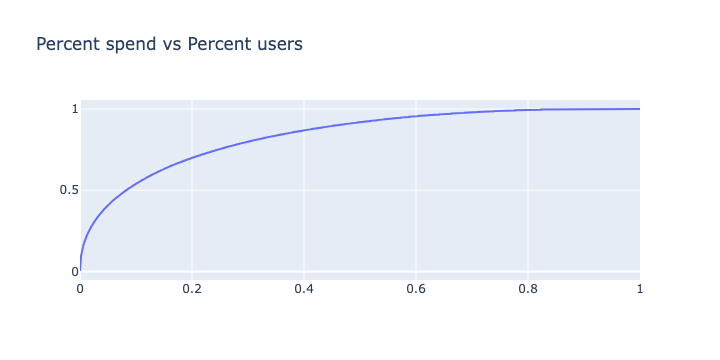

In [6]:

import plotly.graph_objects as go

indexed_df = grouped_df.reset_index()
scatter = go.Scatter(x = indexed_df.index/len(indexed_df.index),
                     y = indexed_df['cum_pct'])
go.Figure(data = [scatter], layout = {'title': 'Percent spend vs Percent users'})

### Identifying power users

Ok so next up is to identify our power users.  We can do so by selecting the rows where the cumulative percentage spend is less than .80, or 80 percent.

In [8]:
power_users_df = grouped_df[grouped_df['cum_pct'] < .80]
power_users_df

sum  cum_pct
customer_id                
1929979702   0.003    0.003
1430453333   0.003    0.006
1884522075   0.003    0.008

In [ ]:
power_users_df

In [36]:
power_users_df.shape, grouped_df.shape

((19558, 2), (64999, 2))

So we can see that 19500 users account for 80 percent of our total revenue.  This is out of a total customer base of almost 65,000.  In other words `30%` of our users account for `80%` of the revenue.  That's pretty close to what our 80 - 20 rule predicted.

It's good to play with this number, for example let's see the number of users that account for 50 percent of our spend.

In [50]:
power_users_df = percent_spend_df[percent_spend_df['percentage_spend'] < .50]
power_users_df.shape, percent_spend_df.shape

((5362, 1), (64999, 1))

In [15]:
5360/64998

0.08246407581771747

So here, we see that just less that 8 percent of our users account for 50 percent of our spend.  It's a judment call, but this seems like an even more interesting subset to analyze.  Let's do that, and stick with our super users.

In [45]:
power_users_df[:2]

sum  cum_pct
customer_id                
1929979702   0.003    0.003
1430453333   0.003    0.006

### Who are the power users

Now that we have the super users, we can try to identify *the behavior* of our super users.  

To do so, we'll want to go back to our original dataset (which remember has multiple transactions per user).  And we want to then just select those rows related to our power user customers.

So to select this subset, we can first set the index of the transactions dataframe to our `customer_id`.

In [12]:
updated_txn_df.index = updated_txn_df.customer_id

Int64Index([1929979702, 1430453333, 1884522075, 1563145168, 1966608472,
            1484892512, 1938889692, 1573160076, 1483274855, 1394568134,
            ...
            1564864795, 1619837871, 1163636021, 2180898432, 2095569914,
            1323520580, 2107660319, 2037508287, 1167923229, 1645188608],
           dtype='int64', name='customer_id', length=19558)

In [18]:
# updated_txn_df.loc[power_users_df.index]

In [39]:
updated_txn_df.index = updated_txn_df.customer_id

And then use `loc` to only select transactions of our power users.

In [46]:
power_users_transactions_df = updated_txn_df.loc[power_users_df.index]

And let's confirm that we have selected a subset of the transactions.

In [47]:
power_users_transactions_df.shape, updated_txn_df.shape

((19967, 21), (65535, 21))

And we can also get our non-power users.

In [50]:
nonpower_ids = grouped_df.index.difference(power_users_df.index)
nonpower_ids.shape

(45441,)

And can again, use loc to just select those power users.

In [51]:
non_power_users_txn_df = updated_txn_df.loc[nonpower_ids]

So now, we have our power users, and these power users's characteristics.

In [59]:
power_users_transactions_df[:2]

Transaction_id  customer_id        Date Product Gender  \
customer_id                                                           
1929979702            15335   1929979702  03/10/2013   Shirt   Male   
1430453333            13787   1430453333  30/09/2013   Shirt   Male   

            Device_Type        Country       State     City  Category  ...  \
customer_id                                                            ...   
1929979702          Web  United States  Washington  Seattle  Clothing  ...   
1430453333          Web  United States  Washington  Seattle  Clothing  ...   

               Delivery_Type  Quantity   Transaction Start  \
customer_id                                                  
1929979702   Normal Delivery         12                  1   
1430453333   Normal Delivery         13                  1   

             Transaction_Result  Amount US$ Individual_Price_US$ Year_Month  \
customer_id                                                                   
1929979702                    1    8,94,869              #VALUE!     13-Oct   
1430453333                    1    8,40,000              #VALUE!     13-Sep   

                 Time individual_price  total_amount  
customer_id                                           
1929979702   13:00:46              NaN      894869.0  
1430453333   06:50:48              NaN      840000.0  

[2 rows x 21 columns]

And the `non_power_users_txn_df`.

In [60]:
non_power_users_txn_df[:2]

Transaction_id  customer_id        Date         Product  Gender  \
customer_id                                                                    
1152937741            56737   1152937741  04/12/2013  Fairness Cream    Male   
1152948204            45073   1152948204  21/11/2013            Jean  Female   

            Device_Type        Country       State     City  Category  ...  \
customer_id                                                            ...   
1152937741          Web  United States  Washington  Seattle   Fashion  ...   
1152948204          Web  United States  Washington  Seattle  Clothing  ...   

               Delivery_Type  Quantity   Transaction Start  \
customer_id                                                  
1152937741   Normal Delivery         21                  1   
1152948204   Normal Delivery         15                  1   

             Transaction_Result  Amount US$ Individual_Price_US$ Year_Month  \
customer_id                                                                   
1152937741                    1           0                    0     13-Dec   
1152948204                    1         800                   53     13-Nov   

                 Time individual_price  total_amount  
customer_id                                           
1152937741   08:20:18              0.0           0.0  
1152948204   02:26:31             53.0         800.0  

[2 rows x 21 columns]

And from here we can use our group by functions to find the characteristics of our power user transactions.

In [52]:
customer_cols = ['Gender', 'State', 'City']

time_cols = ['month', 'week', 'dow', 'hour']

product_cols = ['Product', 'Category', 'individual_price']

channel_cols = ['device_type', 'customer_login_type', 'delivery_type']

transaction_cols = ['transaction_id', 'quantity', 'transaction_start', 'transaction_result']

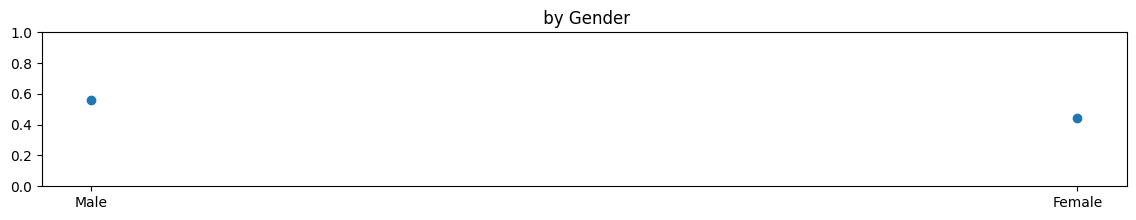

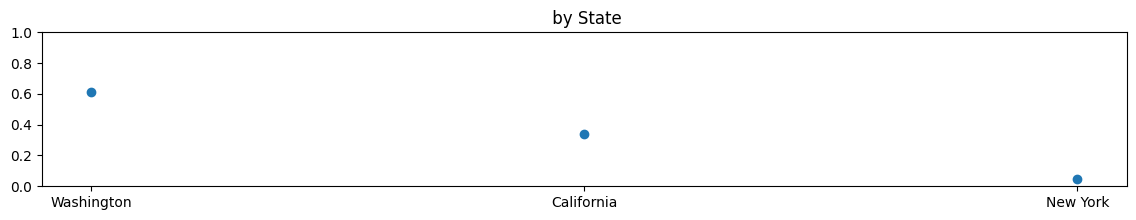

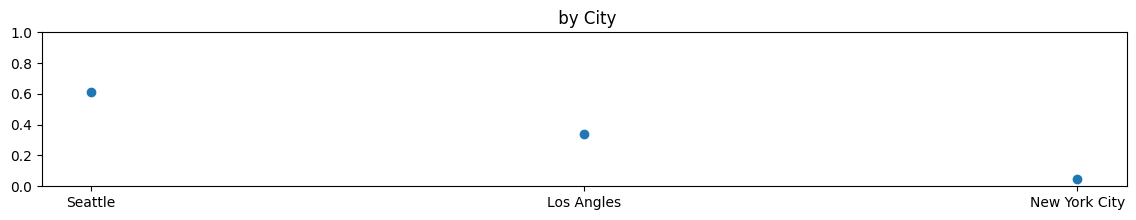

In [53]:
from item_lib import *
target = 'total_amount'
powerusers_customers = build_and_print(power_users_transactions_df,
                                       customer_cols, target, agg = 'sum', agg_name = "", y_range = [0, 1])

And then let's see if this differs from our generic users.

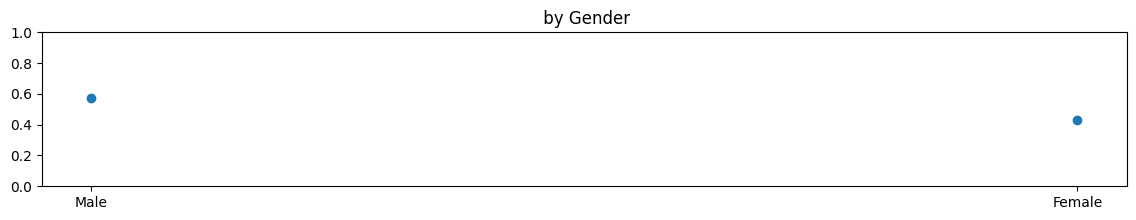

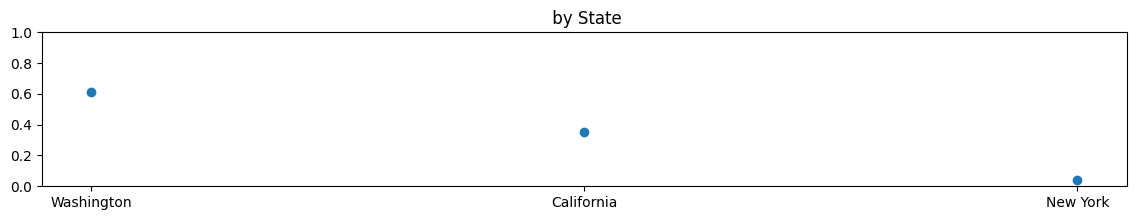

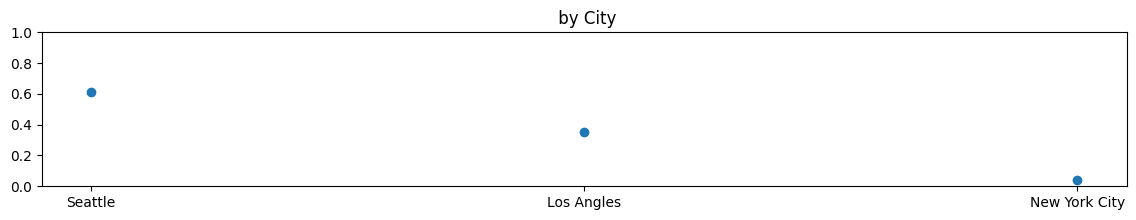

In [54]:
non_powerusers_customers = build_and_print(non_power_users_txn_df, customer_cols, target, agg = 'sum', agg_name = "", y_range = [0, 1])
nonpower = non_powerusers_customers

Not much difference here -- what about in terms of what they purchase.

> Below, we just switch out `customer_cols` for `product_cols`.

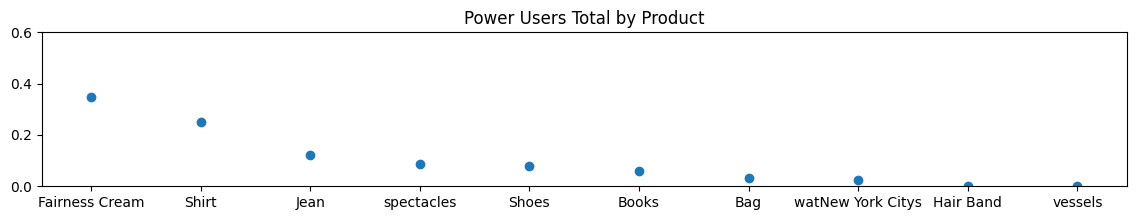

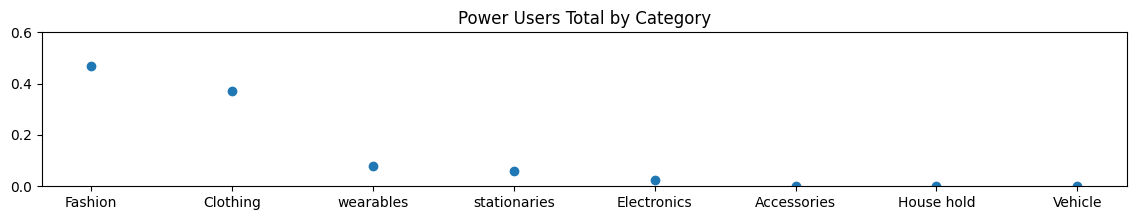

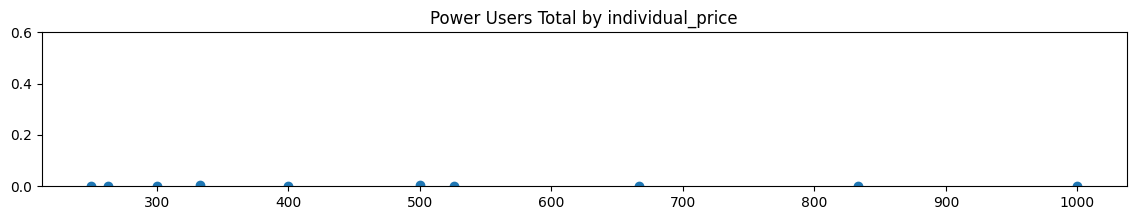

In [55]:
from item_lib import *
target = 'total_amount'
powerusers_customers = build_and_print(power_users_transactions_df,
                                       product_cols, target, agg = 'sum', agg_name = "Power Users Total", y_range = [0, .6])

And compare against our non power users.

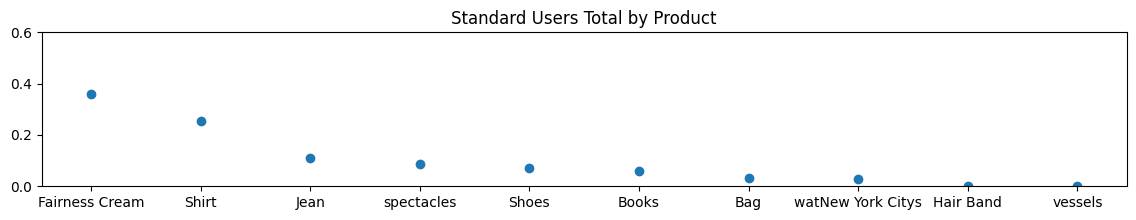

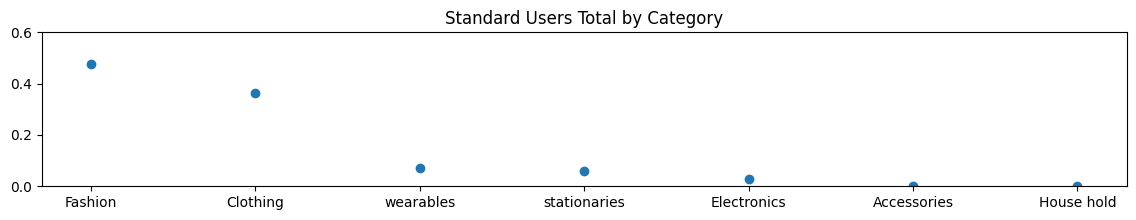

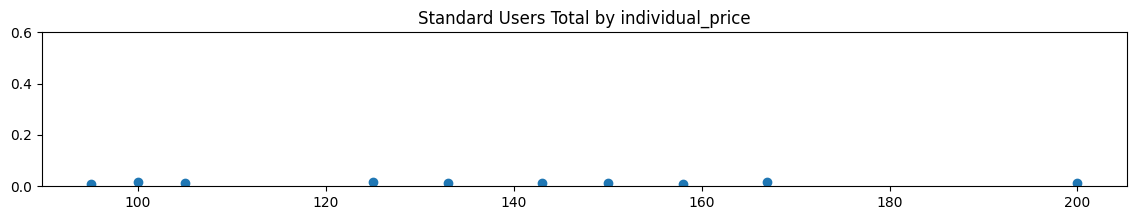

In [56]:
from item_lib import *
target = 'total_amount'
powerusers_customers = build_and_print(non_power_users_txn_df,
                                       product_cols, target, agg = 'sum', agg_name = "Standard Users Total", y_range = [0, .6])

So not much difference by looking at our two kinds of users, but the biggest difference is in the *individual price* of what our users spend.  

This is significant, and we should look at this further.  If individuals are spending a lot on high fashion (and we are getting 50% of our revenue from them), then we should look more closely to see what they are spending on, and make sure we cater to this.

We also would want to think of other strategies to retain these customers in general.  Such a small percentage is accountable for so much.  For example, we can offer them discounts, early access, or free ice cream.

### Summary 

In this lesson, we saw that once we wrote our query to calculate the running percentage spend, we then identified a subset of users as super users -- who accounted for 50 percent of our spend.

From there, we used the index to find the transactions involving our power users.  And we saved this subset of transactions as a new table.  

In [119]:
total_spent_df = updated_txn_df[['customer_id','total_amount']]
total_spent_df[:2]

customer_id  total_amount
customer_id                           
1348959766    1348959766        6910.0
2213674919    2213674919        1699.0

In [21]:
# updated_total_df.groupby('customer_id').sum()['']
totals_per_customer = total_spent_df.groupby('customer_id').sum().sort_values('total_amount', ascending = False)
totals_per_customer[:3]

total_amount
customer_id              
1929979702       894869.0
1430453333       840000.0
1884522075       767733.0

And next we want to turn this into a running total of spend so we can then find users in the top percentile.  

In [22]:
percent_spend = totals_per_customer.cumsum()/totals_per_customer.sum()
percent_spend_df = percent_spend.rename(columns = {'total_amount': 'percentage_spend'})
percent_spend_df[:3]

percentage_spend
customer_id                  
1929979702           0.002978
1430453333           0.005774
1884522075           0.008329

We then went back to our transactions df, to just select transactions by our power users.

In [45]:
# updated_txn_df.index = updated_txn_df.customer_id

In [54]:
power_users_transactions_df = updated_txn_df.loc[power_users_df.index]

Finally, we used our `group_and_print` function to analyze this subset of data, and compare against our non-power users. 

An overall point is that once we have identified an interesting subset of data, we can just use our `group_and_print` functions all over again.  In this case, we did this for our power users, but we also could have done it with another subset of our data, like analyzing users from a particular geographic region.